In [1]:
#import libraries
import pandas as pd
import numpy as np
import os
from glob import glob
import random
import matplotlib.pylab as plt
import keras.backend as K
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import VGG16
%matplotlib inline
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
#load the dataset
imagePatches = glob('/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive=True)
for filename in imagePatches[0:10]:
    print(filename)

/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1351_y1101_class0.png
/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y501_class0.png
/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y1101_class0.png
/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x451_y901_class0.png
/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x801_y451_class0.png
/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x151_y1051_class0.png
/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1351_y901_class0.png
/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x701_y651_class0.png
/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x951_y1401_class0.png
/kaggle/input/breast-histopathology-images/IDC_

In [3]:
# Two arrays holding images by class type

# Create empty lists to store filenames for two classes: no cancer (0) and cancer (1)
class0 = []  # List for filenames of images with no cancer (class 0)
class1 = []  # List for filenames of images with cancer (class 1)

# Iterate through each filename in the 'imagePatches' list
for filename in imagePatches:
    # Check if the filename ends with "class0.png"
    if filename.endswith("class0.png"):
        # If it does, add the filename to the 'class0' list
        class0.append(filename)
    else:
        # If it doesn't end with "class0.png", it belongs to the 'class1' category
        class1.append(filename)

        

In [4]:
import random  # Import the 'random' module for random sampling

# Randomly sample 20,000 filenames from the 'class0' list
sampled_class0 = random.sample(class0, 20000)

# Randomly sample 20,000 filenames from the 'class1' list
sampled_class1 = random.sample(class1, 20000)

# Get the length of the 'sampled_class0' list and print it
sampled_class0_length = len(sampled_class0)
print(sampled_class0_length)


20000


In [5]:
# Print the lengths of the 'sampled_class0' and 'sampled_class1' lists
print(len(sampled_class0), len(sampled_class1))


20000 20000


In [6]:
# Set the image size to 75 (assuming this is the dimension for resizing images)
img_size = 75


In [7]:
from matplotlib.image import imread  # Import the 'imread' function from the 'matplotlib.image' module
import cv2  # Import the OpenCV library for image processing

# Define a function to convert a list of image filenames into resized image arrays
def get_image_arrays(data, label):
    img_arrays = []  # Initialize an empty list to store image arrays
    for i in data:
        if i.endswith('.png'):  # Check if the filename ends with '.png'
            img = cv2.imread(i, cv2.IMREAD_COLOR)  # Read the image using OpenCV in color format
            img_sized = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_LINEAR)  # Resize the image
            img_arrays.append([img_sized, label])  # Append the resized image array along with its label
    return img_arrays  # Return the list of image arrays


In [8]:
# Call the 'get_image_arrays' function to convert sampled class 0 filenames to image arrays with label 0
class0_array = get_image_arrays(sampled_class0, 0)

# Call the 'get_image_arrays' function to convert sampled class 1 filenames to image arrays with label 1
class1_array = get_image_arrays(sampled_class1, 1)


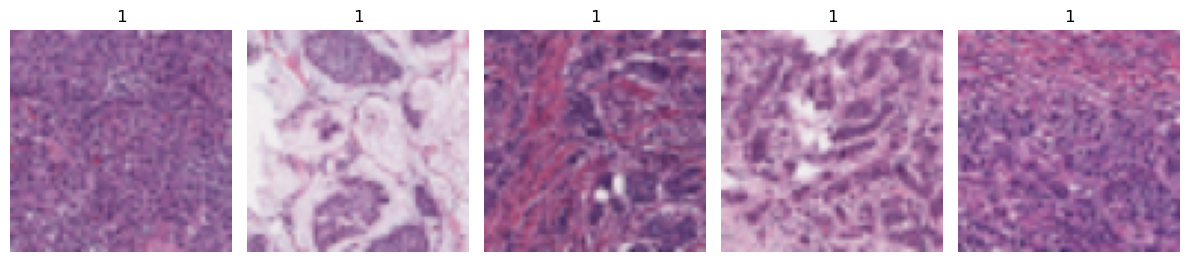

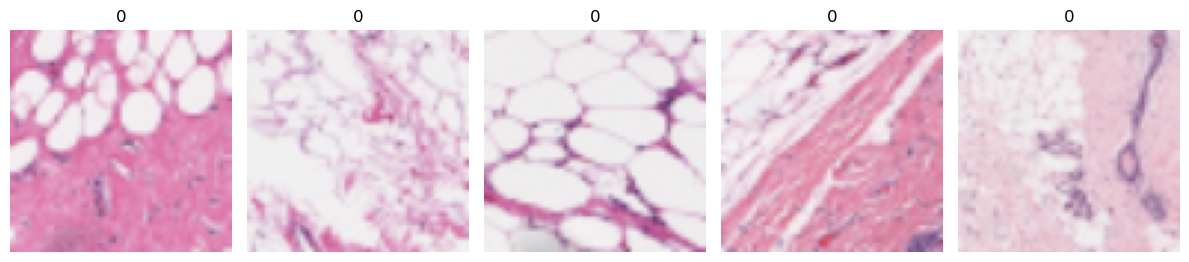

In [9]:
import matplotlib.pyplot as plt  # Import the 'pyplot' module from matplotlib

# Define a function to display sample images along with their labels
def view_samples(img_arrays, num_samples=5):
    # Create a figure with a row of 'num_samples' subplots
    fig, axes = plt.subplots(1, num_samples, figsize=(12, 6))

    # Iterate over the specified number of samples
    for i in range(num_samples):
        img, label = img_arrays[i]  # Get the image array and its label
        axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Display the image with RGB color mapping
        axes[i].set_title(label)  # Set the title of the subplot as the image label
        axes[i].axis('off')  # Turn off the axes for cleaner visualization

    plt.tight_layout()  # Adjust the layout for better spacing
    plt.show()  # Display the figure

# Call the 'view_samples' function to display sample images and labels from 'class1_array'
view_samples(class1_array)

# Call the 'view_samples' function to display sample images and labels from 'class0_array'
view_samples(class0_array)


In [10]:
# Combine the image arrays from class 0 and class 1 into a single array
combined_data = np.concatenate((np.array(class0_array, dtype=object), np.array(class1_array, dtype=object)))


In [11]:
# Initialize empty lists to store features (X) and labels (y)
X = []  # List for features (image arrays)
y = []  # List for labels

# Iterate through the combined_data array, unpacking features and labels
for features, label in combined_data:
    X.append(features)  # Append the image array (features) to the X list
    y.append(label)     # Append the label to the y list


In [12]:
import numpy as np  # Import the NumPy library

# Convert the list of image arrays (X) into a NumPy array and reshape it
X = np.array(X).reshape(-1, img_size, img_size, 3)


In [13]:
# Display the shape of the NumPy array 'X'
print(X.shape)


(40000, 75, 75, 3)


In [14]:
from sklearn.model_selection import train_test_split  # Import the 'train_test_split' function
from keras.utils import to_categorical  # Import the 'to_categorical' function from Keras utilities

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Convert the training and testing labels to categorical format
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Print the shapes of the training and testing sets
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(30000, 75, 75, 3) (10000, 75, 75, 3) (30000, 2) (10000, 2)


In [15]:
from tensorflow.keras.applications.resnet50 import ResNet50

# Import the ResNet-50 model architecture from the TensorFlow Keras library


In [16]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# Import the ResNet-50 model architecture from TensorFlow Keras
base_model = ResNet50(weights='imagenet', include_top=False,
                      input_shape=(img_size, img_size, 3))

# Freeze the layers of the imported ResNet-50 model
base_model.trainable = False

# Add custom top layers on top of the frozen base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(2048, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Print the unfrozen layers to confirm the model architecture
for layer in model.layers:
    if layer.trainable == True:
        print(layer)


94765736/94765736 [==============================] - 0s 0us/step


In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define a list of callbacks for training the model
callbacks = [ModelCheckpoint('resnet50model.hdf5', save_best_only=True)]


In [18]:
from tensorflow.keras.optimizers import Adam

# Define the Adam optimizer with a specific learning rate
opt = Adam(learning_rate=0.000001)

# Compile the model with specified loss function, optimizer, and metrics
model.compile(
    loss='categorical_crossentropy',  # Categorical cross-entropy loss for multi-class classification
    optimizer=opt,  # Adam optimizer with the defined learning rate
    metrics=['accuracy']  # Track accuracy as a metric during training
)


In [19]:
import time
# Start timing the execution of the training process
start_time = time.time()

# Fit the model to the training data and validate on the testing data
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    verbose=1,
    epochs=100,
    callbacks=callbacks
)

# Calculate the elapsed time for the training process
elapsed_time = time.time() - start_time
print("Elapsed Time:", elapsed_time, "seconds")

Epoch 1/100
938/938 [==============================] - 34s 25ms/step - loss: 0.7664 - accuracy: 0.6195 - val_loss: 0.4972 - val_accuracy: 0.7746
Epoch 2/100
938/938 [==============================] - 21s 23ms/step - loss: 0.6476 - accuracy: 0.7031 - val_loss: 0.4756 - val_accuracy: 0.7874
Epoch 3/100
938/938 [==============================] - 21s 23ms/step - loss: 0.6049 - accuracy: 0.7282 - val_loss: 0.4593 - val_accuracy: 0.7983
Epoch 4/100
938/938 [==============================] - 21s 23ms/step - loss: 0.5793 - accuracy: 0.7412 - val_loss: 0.4484 - val_accuracy: 0.8037
Epoch 5/100
938/938 [==============================] - 21s 23ms/step - loss: 0.5602 - accuracy: 0.7533 - val_loss: 0.4412 - val_accuracy: 0.8083
Epoch 6/100
938/938 [==============================] - 22s 23ms/step - loss: 0.5454 - accuracy: 0.7584 - val_loss: 0.4361 - val_accuracy: 0.8104
Epoch 7/100
938/938 [==============================] - 22s 23ms/step - loss: 0.5337 - accuracy: 0.7625 - val_loss: 0.4323 - val_ac

In [20]:
import tensorflow.keras.backend as K

# Define a custom F1-score function using Keras backend functions
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    
    return f1_val


In [21]:

# List of metrics to be used during model compilation
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    f1_score,  # Custom F1-score metric
]

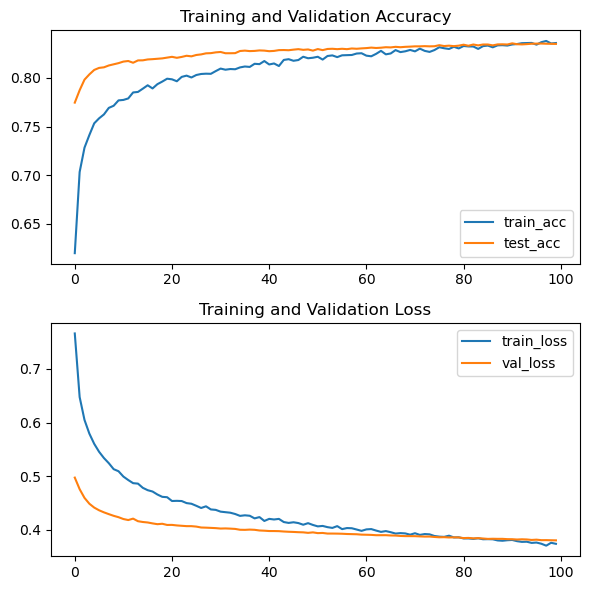

In [22]:
import matplotlib.pyplot as plt  # Import the 'pyplot' module from matplotlib

# Create a figure with two subplots
plt.figure(figsize=(6, 6))
plt.subplot(2, 1, 1)  # Subplot for accuracy
plt.plot(history.history['accuracy'], label="train_acc")  # Plot training accuracy
plt.plot(history.history['val_accuracy'], label="test_acc")  # Plot validation accuracy
plt.legend()  # Add legend
plt.title("Training and Validation Accuracy")  # Add title to subplot

plt.subplot(2, 1, 2)  # Subplot for loss
plt.plot(history.history['loss'], label="train_loss")  # Plot training loss
plt.plot(history.history['val_loss'], label="val_loss")  # Plot validation loss
plt.legend()  # Add legend
plt.title("Training and Validation Loss")  # Add title to subplot

plt.tight_layout()  # Adjust layout for better spacing
plt.show()  # Display the plots


313/313 [==============================] - 5s 13ms/step


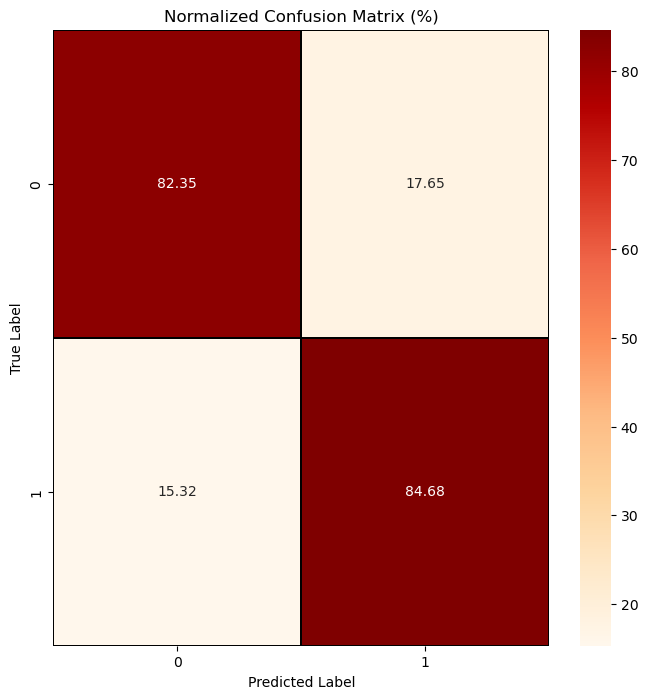

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict the classes for the test data
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(y_test, axis=1)

# Generate confusion matrix plot
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Calculate normalized confusion matrix
confusion_mtx_normalized = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis]

# Convert to percentage format
confusion_mtx_normalized_percentage = confusion_mtx_normalized * 100

# Plot the normalized confusion matrix with percentage values
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx_normalized_percentage, annot=True, linewidths=0.01, cmap="OrRd", linecolor="black", fmt='.2f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix (%)")
plt.show()


In [24]:
from sklearn.metrics import classification_report

# Generate and print the classification report
print(classification_report(Y_true, Y_pred_classes))


              precision    recall  f1-score   support

           0       0.84      0.82      0.83      5021
           1       0.83      0.85      0.84      4979

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



1/1 [==============================] - 0s 21ms/step


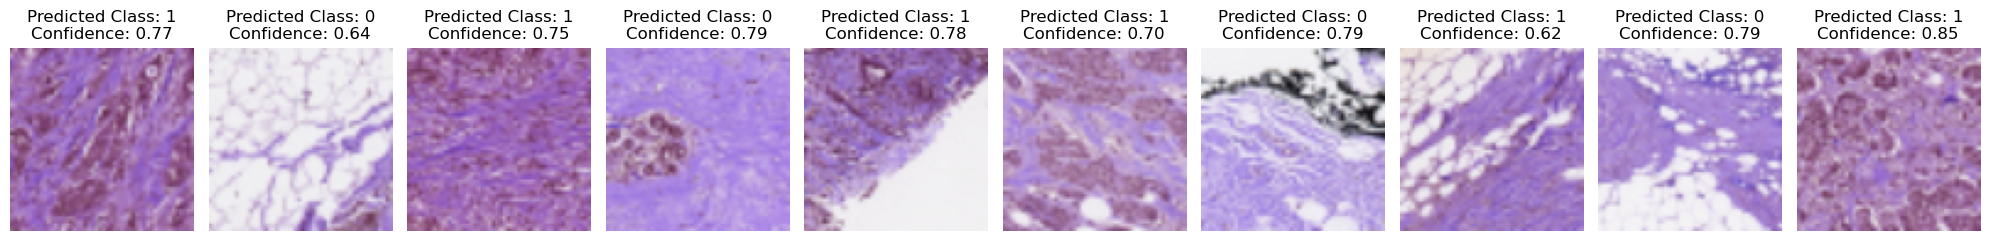

In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

def predict_image_classes(x_test, model_path, class_labels):
    # Load the pre-trained model
    model = load_model(model_path)
    
    # Get the target size from the model input shape
    target_size = tuple(model.input.shape[1:3])
    
    predictions = []
    
    for image in x_test:
        
        # Perform inference
        prediction = model.predict(np.expand_dims(image, axis=0))[0]
        predicted_class_index = np.argmax(prediction)
        predicted_class = class_labels[predicted_class_index]
        confidence = prediction[predicted_class_index]
        
        predictions.append((image, predicted_class, confidence))
    
    return predictions

def display_predictions(predictions):
    num_images = len(predictions)
    fig, axes = plt.subplots(1, num_images, figsize=(20, 6))

    for i, (image, predicted_class, confidence) in enumerate(predictions):
        axes[i].imshow(image)
        axes[i].set_title(f"Predicted Class: {predicted_class}\nConfidence: {confidence:.2f}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
x_test = X_test[:10]  # List of images from your x_test dataset
model_path = 'resnet50model.hdf5'  # Path to your trained model file
class_labels = [0, 1]  # List of class labels

predictions = predict_image_classes(x_test, model_path, class_labels)
display_predictions(predictions)


In [26]:
from tensorflow.keras.applications.vgg16 import VGG16

# Import the VGG16 model architecture from the TensorFlow Keras library


In [27]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# Import the VGG16 model architecture from TensorFlow Keras
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the layers of the imported VGG16 model
vgg16_model.trainable = False

# Add custom top layers on top of the frozen VGG16 base model
x = vgg16_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(2048, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='sigmoid')(x)
vgg16_model = Model(inputs=vgg16_model.input, outputs=predictions)

# Print the unfrozen layers to confirm the model architecture
for layer in vgg16_model.layers:
    if layer.trainable == True:
        print(layer)


58889256/58889256 [==============================] - 0s 0us/step


In [28]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define a list of callbacks for training the VGG16 model
callbacks = [ModelCheckpoint('vgg16model.hdf5', save_best_only=True)]


In [29]:
from tensorflow.keras.optimizers import Adam

# Define the Adam optimizer with a specific learning rate
opt = Adam(learning_rate=0.000001)

# Compile the VGG16 model with specified loss function, optimizer, and metrics
vgg16_model.compile(
    loss='categorical_crossentropy',  # Categorical cross-entropy loss for multi-class classification
    optimizer=opt,  # Adam optimizer with the defined learning rate
    metrics=['accuracy']  # Track accuracy as a metric during training
)


In [ ]:
# Record the start time using the time module
start_time = time.time()

# Fit the VGG16 model to the training data and validate on the testing data
vgg16history = vgg16_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    verbose=1,
    epochs=100,
    callbacks=callbacks
)

# Calculate and print the elapsed time for the training process
elapsed_time = time.time() - start_time
print("Elapsed Time:", elapsed_time, "seconds")

Epoch 1/100
938/938 [==============================] - 22s 21ms/step - loss: 3.0243 - accuracy: 0.5351 - val_loss: 0.9140 - val_accuracy: 0.6832
Epoch 2/100
938/938 [==============================] - 17s 18ms/step - loss: 2.3700 - accuracy: 0.5918 - val_loss: 0.8840 - val_accuracy: 0.7410
Epoch 3/100
938/938 [==============================] - 18s 20ms/step - loss: 2.1325 - accuracy: 0.6286 - val_loss: 0.8628 - val_accuracy: 0.7634
Epoch 4/100
938/938 [==============================] - 17s 18ms/step - loss: 1.9786 - accuracy: 0.6541 - val_loss: 0.8602 - val_accuracy: 0.7708
Epoch 5/100
938/938 [==============================] - 18s 20ms/step - loss: 1.8411 - accuracy: 0.6660 - val_loss: 0.8432 - val_accuracy: 0.7767
Epoch 6/100
938/938 [==============================] - 18s 20ms/step - loss: 1.8159 - accuracy: 0.6712 - val_loss: 0.8436 - val_accuracy: 0.7789
Epoch 7/100
938/938 [==============================] - 18s 19ms/step - loss: 1.7048 - accuracy: 0.6806 - val_loss: 0.8062 - val_ac

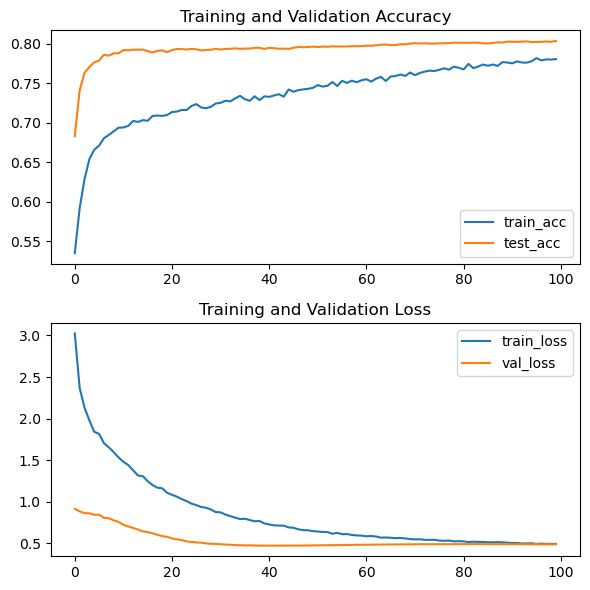

In [43]:
import matplotlib.pyplot as plt  # Import the 'pyplot' module from matplotlib

# Create a figure with two subplots
plt.figure(figsize=(6, 6))
plt.subplot(2, 1, 1)  # Subplot for accuracy
plt.plot(vgg16history.history['accuracy'], label="train_acc")  # Plot training accuracy
plt.plot(vgg16history.history['val_accuracy'], label="test_acc")  # Plot validation accuracy
plt.legend()  # Add legend
plt.title("Training and Validation Accuracy")  # Add title to subplot

plt.subplot(2, 1, 2)  # Subplot for loss
plt.plot(vgg16history.history['loss'], label="train_loss")  # Plot training loss
plt.plot(vgg16history.history['val_loss'], label="val_loss")  # Plot validation loss
plt.legend()  # Add legend
plt.title("Training and Validation Loss")  # Add title to subplot

plt.tight_layout()  # Adjust layout for better spacing
plt.show()  # Display the plots


313/313 [==============================] - 3s 11ms/step


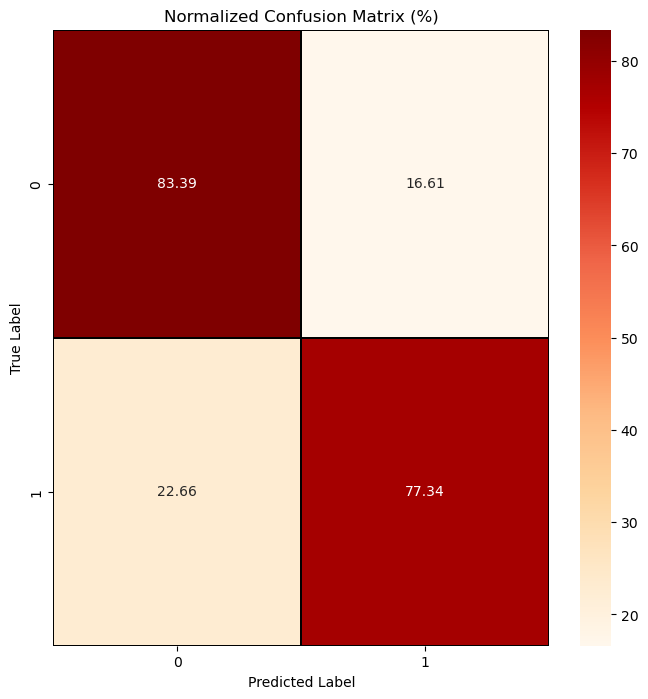

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict the classes for the test data using the VGG16 model
Y_pred = vgg16_model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(y_test, axis=1)

# Generate confusion matrix plot
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Calculate normalized confusion matrix
confusion_mtx_normalized = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis]

# Convert to percentage format
confusion_mtx_normalized_percentage = confusion_mtx_normalized * 100

# Plot the normalized confusion matrix with percentage values
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx_normalized_percentage, annot=True, linewidths=0.01, cmap="OrRd", linecolor="black", fmt='.2f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix (%)")
plt.show()



In [45]:
from sklearn.metrics import classification_report

# Generate and print the classification report
print(classification_report(Y_true, Y_pred_classes))


              precision    recall  f1-score   support

           0       0.79      0.83      0.81      5021
           1       0.82      0.77      0.80      4979

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000



1/1 [==============================] - 0s 18ms/step


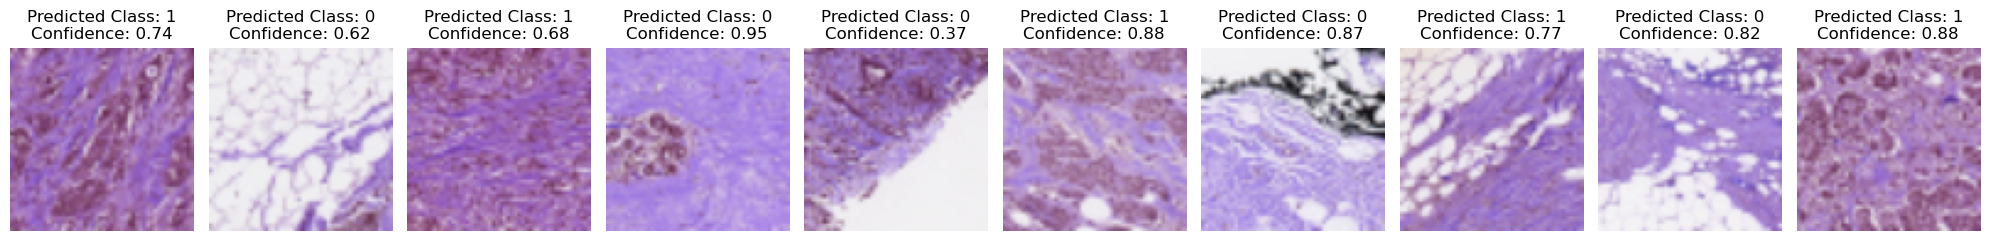

In [46]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

def predict_image_classes(x_test, model_path, class_labels):
    # Load the pre-trained model
    model = load_model(model_path)
    
    # Get the target size from the model input shape
    target_size = tuple(model.input.shape[1:3])
    
    predictions = []
    
    for image in x_test:
        
        # Perform inference
        prediction = model.predict(np.expand_dims(image, axis=0))[0]
        predicted_class_index = np.argmax(prediction)
        predicted_class = class_labels[predicted_class_index]
        confidence = prediction[predicted_class_index]
        
        predictions.append((image, predicted_class, confidence))
    
    return predictions

def display_predictions(predictions):
    num_images = len(predictions)
    fig, axes = plt.subplots(1, num_images, figsize=(20, 6))

    for i, (image, predicted_class, confidence) in enumerate(predictions):
        axes[i].imshow(image)
        axes[i].set_title(f"Predicted Class: {predicted_class}\nConfidence: {confidence:.2f}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


x_test = X_test[:10]  # List of images from your x_test dataset
model_path = 'vgg16model.hdf5'  # Path to your trained model file
class_labels = [0, 1]  # List of class labels

predictions = predict_image_classes(x_test, model_path, class_labels)
display_predictions(predictions)


In [35]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import time

# Define the Xception model architecture
xception_model = Xception(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the layers of the imported Xception model
xception_model.trainable = False

# Add custom top layers on top of the frozen Xception base model
x = xception_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(4096, activation="relu")(x)
x = Dense(4096, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(2096, activation="relu")(x)
predictions = Dense(2, activation='sigmoid')(x)
xception_model = Model(inputs=xception_model.input, outputs=predictions)

# Print the unfrozen layers to confirm the model architecture
for layer in xception_model.layers:
    if layer.trainable == True:
        print(layer)

# Define a list of callbacks for training the Xception model
callbacks = [ModelCheckpoint('xceptionmodel.hdf5', save_best_only=True)]

# Define the optimizer with a specific learning rate
opt = Adam(learning_rate=0.000001)

# Compile the Xception model with specified loss function, optimizer, and metrics
xception_model.compile(
    loss='categorical_crossentropy',  # Categorical cross-entropy loss for multi-class classification
    optimizer=opt,  # Adam optimizer with the defined learning rate
    metrics=['accuracy']  # Track accuracy as a metric during training
)

# Record the start time using the time module
start_time = time.time()

# Fit the Xception model to the training data and validate on the testing data
xceptionhistory = xception_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    verbose=1,
    epochs=100,
    callbacks=callbacks
)

# Calculate and print the elapsed time for the training process
elapsed_time = time.time() - start_time
print("Elapsed Time:", elapsed_time, "seconds")


938/938 [==============================] - 25s 26ms/step - loss: 1.4346 - accuracy: 0.6582 - val_loss: 1.0448 - val_accuracy: 0.7304
Epoch 3/100
938/938 [==============================] - 24s 26ms/step - loss: 1.2315 - accuracy: 0.6634 - val_loss: 0.7823 - val_accuracy: 0.7484
Epoch 4/100
938/938 [==============================] - 24s 26ms/step - loss: 1.1069 - accuracy: 0.6733 - val_loss: 0.7517 - val_accuracy: 0.7491
Epoch 5/100
938/938 [==============================] - 24s 26ms/step - loss: 1.0253 - accuracy: 0.6701 - val_loss: 0.7347 - val_accuracy: 0.7482
Epoch 6/100
938/938 [==============================] - 24s 26ms/step - loss: 0.9631 - accuracy: 0.6749 - val_loss: 0.6505 - val_accuracy: 0.7443
Epoch 7/100
938/938 [==============================] - 24s 25ms/step - loss: 0.8957 - accuracy: 0.6781 - val_loss: 0.6431 - val_accuracy: 0.7457
Epoch 8/100
938/938 [==============================] - 24s 26ms/step - loss: 0.8572 - accuracy: 0.6812 - val_loss: 0.5862 - val_accuracy: 0.75

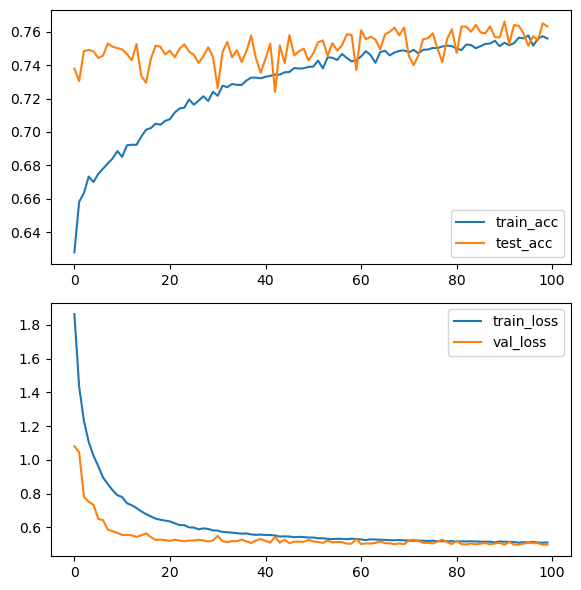

313/313 [==============================] - 5s 13ms/step


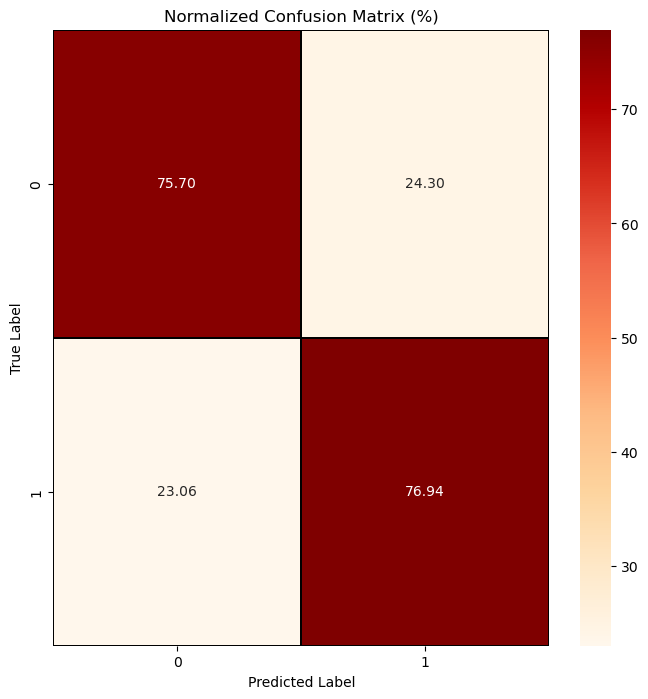

              precision    recall  f1-score   support

           0       0.77      0.76      0.76      5021
           1       0.76      0.77      0.76      4979

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000



In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Plot the accuracy and loss graphs
plt.figure(figsize=(6, 6))
plt.subplot(2, 1, 1)
plt.plot(xceptionhistory.history['accuracy'], label="train_acc")
plt.plot(xceptionhistory.history['val_accuracy'], label="test_acc")
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(xceptionhistory.history['loss'], label="train_loss")
plt.plot(xceptionhistory.history['val_loss'], label="val_loss")
plt.legend()
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

# Predict the classes for the test data using the Xception model
Y_pred = xception_model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(y_test, axis=1)

# Generate confusion matrix plot
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Calculate normalized confusion matrix
confusion_mtx_normalized = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis]

# Convert to percentage format
confusion_mtx_normalized_percentage = confusion_mtx_normalized * 100

# Plot the normalized confusion matrix with percentage values
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx_normalized_percentage, annot=True, linewidths=0.01, cmap="OrRd", linecolor="black", fmt='.2f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix (%)")
plt.show()


# Generate and print the classification report
print(classification_report(Y_true, Y_pred_classes))


1/1 [==============================] - 0s 20ms/step


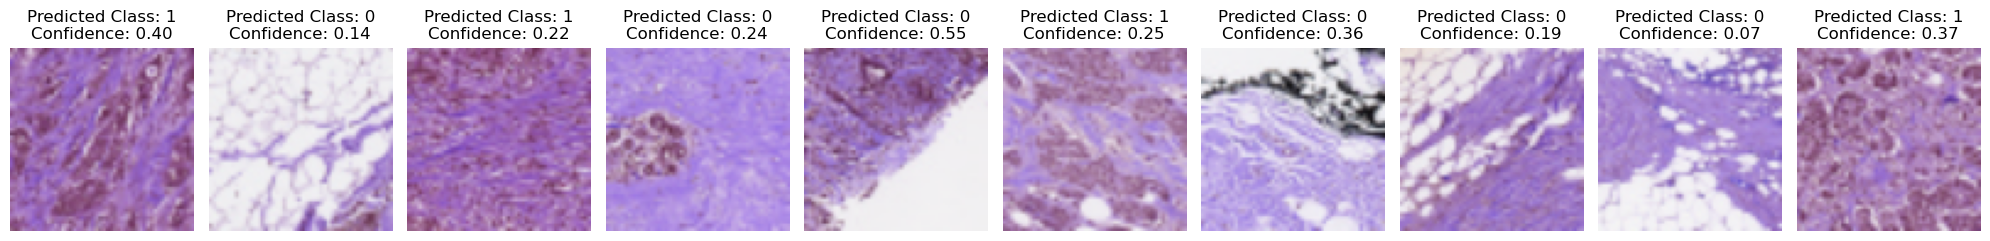

In [37]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

def predict_image_classes(x_test, model_path, class_labels):
    # Load the pre-trained model
    model = load_model(model_path)

    # Get the target size from the model input shape
    target_size = tuple(model.input.shape[1:3])

    predictions = []

    for image in x_test:

        # Perform inference
        prediction = model.predict(np.expand_dims(image, axis=0))[0]
        predicted_class_index = np.argmax(prediction)
        predicted_class = class_labels[predicted_class_index]
        confidence = prediction[predicted_class_index]

        predictions.append((image, predicted_class, confidence))

    return predictions

def display_predictions(predictions):
    num_images = len(predictions)
    fig, axes = plt.subplots(1, num_images, figsize=(20, 6))

    for i, (image, predicted_class, confidence) in enumerate(predictions):
        axes[i].imshow(image)
        axes[i].set_title(f"Predicted Class: {predicted_class}\nConfidence: {confidence:.2f}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
x_test = X_test[:10]  # List of images from your x_test dataset
model_path = 'xceptionmodel.hdf5'  # Path to your trained model file
class_labels = [0, 1]  # List of class labels

predictions = predict_image_classes(x_test, model_path, class_labels)
display_predictions(predictions)


In [38]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import time

# Define the DenseNet121 model architecture
densenet_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the layers of the imported DenseNet121 model
densenet_model.trainable = False

# Add custom top layers on top of the frozen DenseNet121 base model
x = densenet_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(4096, activation="relu")(x)
x = Dense(4096, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(2096, activation="relu")(x)
predictions = Dense(2, activation='sigmoid')(x)
densenet_model = Model(inputs=densenet_model.input, outputs=predictions)

# Print the unfrozen layers to confirm the model architecture
for layer in densenet_model.layers:
    if layer.trainable == True:
        print(layer)

# Define a list of callbacks for training the DenseNet121 model
callbacks = [ModelCheckpoint('densenetmodel.hdf5', save_best_only=True)]

# Define the optimizer with a specific learning rate
opt = Adam(learning_rate=0.000001)

# Compile the DenseNet121 model with specified loss function, optimizer, and metrics
densenet_model.compile(
    loss='categorical_crossentropy',  # Categorical cross-entropy loss for multi-class classification
    optimizer=opt,  # Adam optimizer with the defined learning rate
    metrics=['accuracy']  # Track accuracy as a metric during training
)

# Record the start time using the time module
start_time = time.time()

# Fit the DenseNet121 model to the training data and validate on the testing data
densenethistory = densenet_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    verbose=1,
    epochs=100,
    callbacks=callbacks
)

# Calculate and print the elapsed time for the training process
elapsed_time = time.time() - start_time
print("Elapsed Time:", elapsed_time, "seconds")


29084464/29084464 [==============================] - 0s 0us/step
Epoch 1/100
938/938 [==============================] - 36s 29ms/step - loss: 1.1060 - accuracy: 0.6684 - val_loss: 0.5883 - val_accuracy: 0.7860
Epoch 2/100
938/938 [==============================] - 24s 26ms/step - loss: 0.8805 - accuracy: 0.7064 - val_loss: 0.5866 - val_accuracy: 0.7896
Epoch 3/100
938/938 [==============================] - 25s 26ms/step - loss: 0.7872 - accuracy: 0.7190 - val_loss: 0.5682 - val_accuracy: 0.7925
Epoch 4/100
938/938 [==============================] - 24s 26ms/step - loss: 0.7477 - accuracy: 0.7238 - val_loss: 0.4874 - val_accuracy: 0.7943
Epoch 5/100
938/938 [==============================] - 24s 26ms/step - loss: 0.6988 - accuracy: 0.7298 - val_loss: 0.4771 - val_accuracy: 0.8006
Epoch 6/100
938/938 [==============================] - 23s 24ms/step - loss: 0.6814 - accuracy: 0.7316 - val_loss: 0.5091 - val_accuracy: 0.7975
Epoch 7/100
938/938 [==============================] - 23s 24ms/s

313/313 [==============================] - 7s 16ms/step


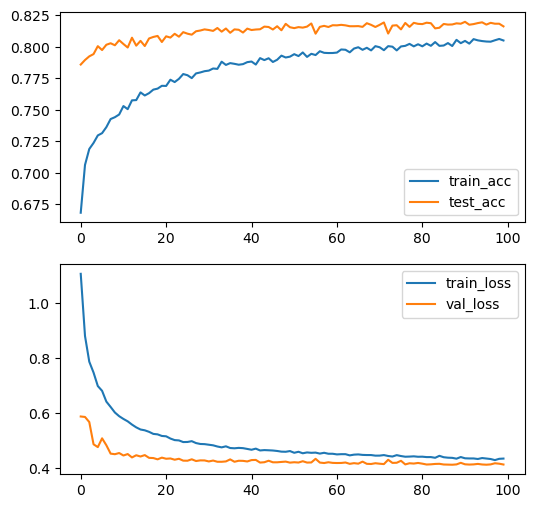

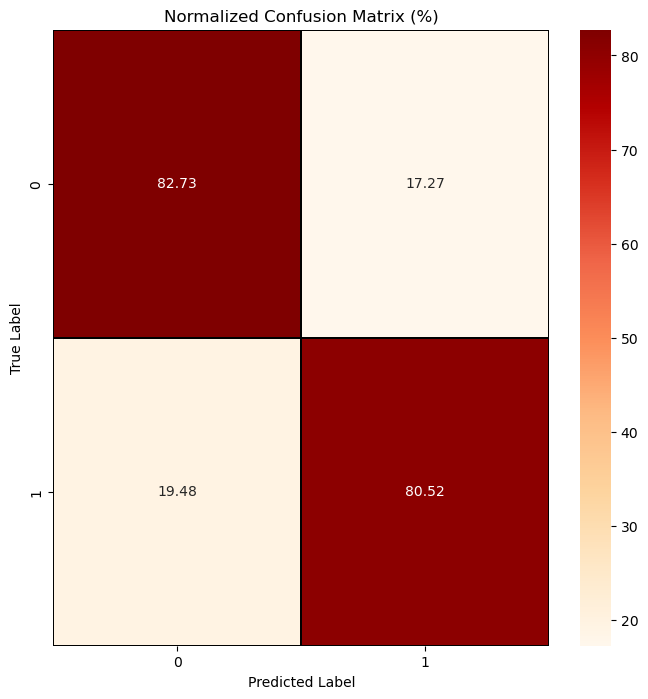

              precision    recall  f1-score   support

           0       0.81      0.83      0.82      5021
           1       0.82      0.81      0.81      4979

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000

1/1 [==============================] - 0s 31ms/step


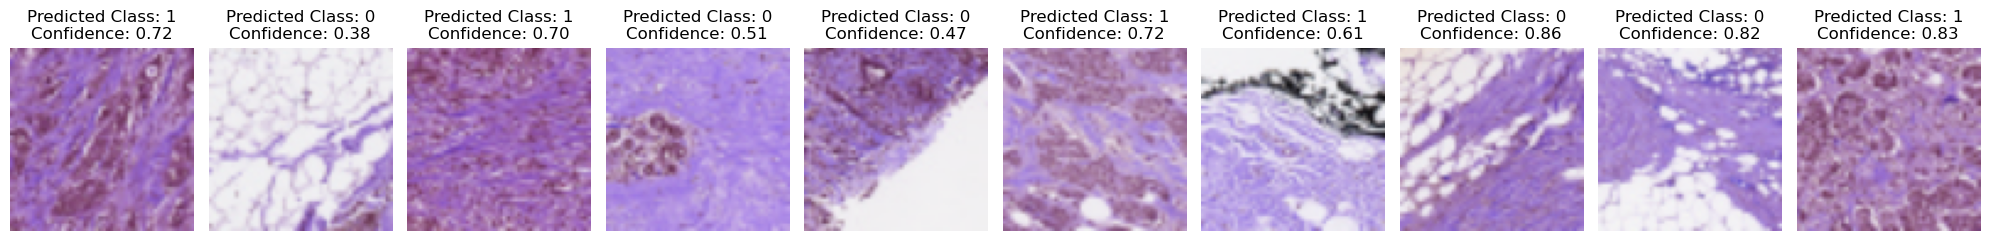

In [39]:
#plot the accuracy graph
plt.figure(figsize = (6,6))
plt.subplot(2,1,1)
plt.plot(densenethistory.history['accuracy'], label="train_acc")
plt.plot(densenethistory.history['val_accuracy'], label = "test_acc")
plt.legend()
plt.subplot(2,1,2)
plt.plot(densenethistory.history['loss'], label = "train_loss")
plt.plot(densenethistory.history['val_loss'], label = "val_loss")
plt.legend()
from sklearn.metrics import confusion_matrix
import seaborn as sns

Y_pred = densenet_model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(y_test,axis = 1)

# Generate confusion matrix plot
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Calculate normalized confusion matrix
confusion_mtx_normalized = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis]

# Convert to percentage format
confusion_mtx_normalized_percentage = confusion_mtx_normalized * 100

# Plot the normalized confusion matrix with percentage values
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx_normalized_percentage, annot=True, linewidths=0.01, cmap="OrRd", linecolor="black", fmt='.2f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix (%)")
plt.show()

from sklearn.metrics import classification_report

print(classification_report(Y_true, Y_pred_classes))
import cv2
import numpy as np
from tensorflow.keras.models import load_model



def predict_image_classes(x_test, model_path, class_labels):
    # Load the pre-trained model
    model = load_model(model_path)

    # Get the target size from the model input shape
    target_size = tuple(model.input.shape[1:3])

    predictions = []

    for image in x_test:

        # Perform inference
        prediction = model.predict(np.expand_dims(image, axis=0))[0]
        predicted_class_index = np.argmax(prediction)
        predicted_class = class_labels[predicted_class_index]
        confidence = prediction[predicted_class_index]

        predictions.append((image,predicted_class, confidence))

    return predictions

def display_predictions(predictions):
    num_images = len(predictions)
    fig, axes = plt.subplots(1, num_images, figsize=(20, 6))

    for i, (image, predicted_class, confidence) in enumerate(predictions):
        axes[i].imshow(image)
        axes[i].set_title(f"Predicted Class: {predicted_class}\nConfidence: {confidence:.2f}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


x_test = X_test[:10] # List of images from your x_test dataset
model_path = 'densenetmodel.hdf5'  # Path to your trained model file
class_labels = [0,1]  # List of class labels

predictions = predict_image_classes(x_test, model_path, class_labels)
display_predictions(predictions)

17225924/17225924 [==============================] - 0s 0us/step
Epoch 1/100
938/938 [==============================] - 14s 11ms/step - loss: 0.7260 - accuracy: 0.5348 - val_loss: 0.6377 - val_accuracy: 0.6564
Epoch 2/100
938/938 [==============================] - 11s 11ms/step - loss: 0.6609 - accuracy: 0.6158 - val_loss: 0.5925 - val_accuracy: 0.7144
Epoch 3/100
938/938 [==============================] - 10s 11ms/step - loss: 0.6258 - accuracy: 0.6572 - val_loss: 0.5644 - val_accuracy: 0.7346
Epoch 4/100
938/938 [==============================] - 10s 10ms/step - loss: 0.5989 - accuracy: 0.6856 - val_loss: 0.5468 - val_accuracy: 0.7479
Epoch 5/100
938/938 [==============================] - 10s 11ms/step - loss: 0.5847 - accuracy: 0.7024 - val_loss: 0.5353 - val_accuracy: 0.7535
Epoch 6/100
938/938 [==============================] - 10s 10ms/step - loss: 0.5713 - accuracy: 0.7142 - val_loss: 0.5276 - val_accuracy: 0.7574
Epoch 7/100
938/938 [==============================] - 10s 11ms/s

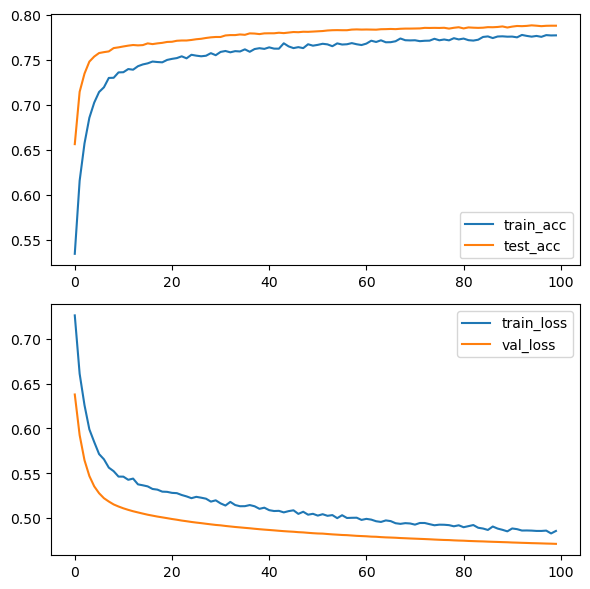

313/313 [==============================] - 2s 5ms/step


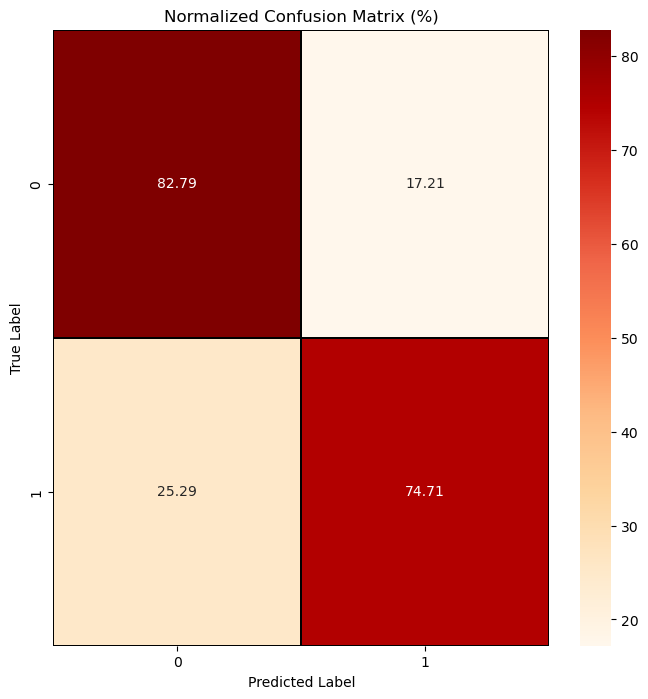

              precision    recall  f1-score   support

           0       0.77      0.83      0.80      5021
           1       0.81      0.75      0.78      4979

    accuracy                           0.79     10000
   macro avg       0.79      0.79      0.79     10000
weighted avg       0.79      0.79      0.79     10000

1/1 [==============================] - 0s 19ms/step


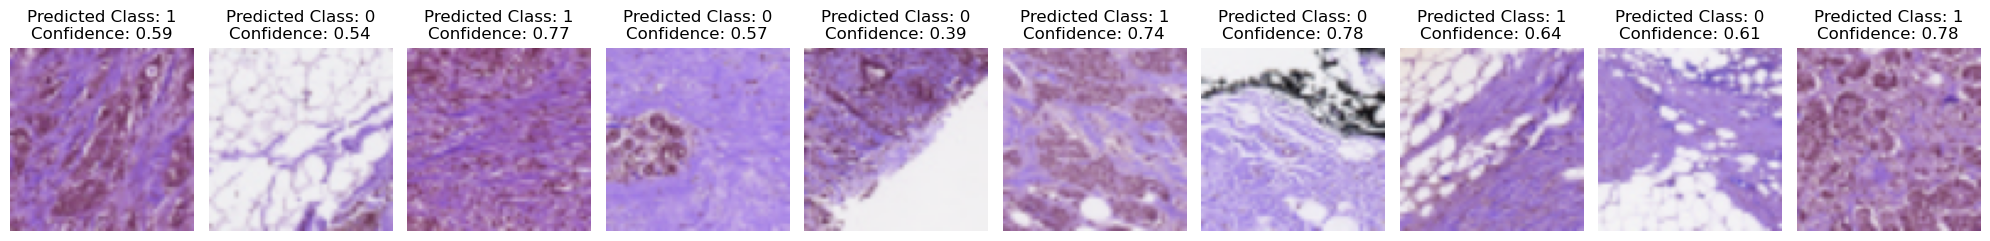

In [40]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import time

# Define the MobileNet model architecture
mobilenet_model = MobileNet(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the layers of the imported MobileNet model
mobilenet_model.trainable = False

# Add custom top layers on top of the frozen MobileNet base model
x = mobilenet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(2048, activation="relu")(x)
x = Dense(2048, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.2)(x)
predictions = Dense(2, activation='sigmoid')(x)
mobilenet_model = Model(inputs=mobilenet_model.input, outputs=predictions)

# Print the unfrozen layers to confirm the model architecture
for layer in mobilenet_model.layers:
    if layer.trainable == True:
        print(layer)

# Define a list of callbacks for training the MobileNet model
callbacks = [ModelCheckpoint('mobilenetmodel.hdf5', save_best_only=True)]

# Define the optimizer with a specific learning rate
opt = Adam(learning_rate=0.0000001)

# Compile the MobileNet model with specified loss function, optimizer, and metrics
mobilenet_model.compile(
    loss='categorical_crossentropy',  # Categorical cross-entropy loss for multi-class classification
    optimizer=opt,  # Adam optimizer with the defined learning rate
    metrics=['accuracy']  # Track accuracy as a metric during training
)

# Record the start time using the time module
start_time = time.time()

# Fit the MobileNet model to the training data and validate on the testing data
mobilenethistory = mobilenet_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    verbose=1,
    epochs=100,
    callbacks=callbacks
)

# Calculate and print the elapsed time for the training process
elapsed_time = time.time() - start_time
print("Elapsed Time:", elapsed_time, "seconds")

# Plot the accuracy and loss graphs
plt.figure(figsize=(6, 6))
plt.subplot(2, 1, 1)
plt.plot(mobilenethistory.history['accuracy'], label="train_acc")
plt.plot(mobilenethistory.history['val_accuracy'], label="test_acc")
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(mobilenethistory.history['loss'], label="train_loss")
plt.plot(mobilenethistory.history['val_loss'], label="val_loss")
plt.legend()
plt.tight_layout()
plt.show()

# Predict the classes for the test data using the MobileNet model
Y_pred = mobilenet_model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(y_test, axis=1)

# Generate confusion matrix plot
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Calculate normalized confusion matrix
confusion_mtx_normalized = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis]

# Convert to percentage format
confusion_mtx_normalized_percentage = confusion_mtx_normalized * 100

# Plot the normalized confusion matrix with percentage values
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx_normalized_percentage, annot=True, linewidths=0.01, cmap="OrRd", linecolor="black", fmt='.2f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix (%)")
plt.show()


# Generate and print the classification report
print(classification_report(Y_true, Y_pred_classes))

# Define a function to predict and display image classes
def predict_and_display(x_test, model_path, class_labels):
    # Predict image classes
    predictions = predict_image_classes(x_test, model_path, class_labels)

    # Display predictions
    display_predictions(predictions)

# Example usage
x_test_subset = X_test[:10]  # List of images from your x_test dataset
model_path = 'mobilenetmodel.hdf5'  # Path to your trained model file
class_labels = [0, 1]  # List of class labels

# Call the function to predict and display image classes
predict_and_display(x_test_subset, model_path, class_labels)
